<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D3_NetworkCausality/W3D3_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Causality : Model Based Inference

**Content creators**: Ari Benjamin, Tony Liu, Konrad Kording

**Content modified**: Kai Chen

---
# Tutorial objectives

1.   Master definitions of causality
2.   Understand that estimating causality is possible
3.   Infer causality with model based method: simultaneous fitting/regression

#### References:
- D. Zhou, Y. Xiao, Y. Zhang, Z. Xu and D. Cai, “Granger causality network reconstruction of conductance-based integrate-and-fire neuronal systems”, PLoS ONE, 9 (2), e87636, 2014. ([PDF](https://ins.sjtu.edu.cn/people/zdz/publication_papers/Granger_Causality_Reconstruction.pdf))
- Matlab-based fast GC-estimator: [GC_clean](https://github.com/bewantbe/GC_clean)
- SciPy $\chi^2$ statistics [documents](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html).

---
# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso, LinearRegression
from scipy.stats import chi2

In [2]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeoNeuron/professional-workshop-3/master/nma.mplstyle")

In [3]:
# @title Helper functions


def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def logit(x):
    """

    Applies the logit (inverse sigmoid) transformation

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))


def create_connectivity(n_neurons, random_state=42, p=0.1):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[1 - p, p])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def get_regression_estimate_full_connectivity(X):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    reg = MultiOutputRegressor(Lasso(fit_intercept=False,
                                     alpha=0.01, max_iter=250 ), n_jobs=-1)
    reg.fit(W, Y)

    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(reg.estimators_):
        V[i, :] = estimator.coef_

    return V


def get_regression_corr_full_connectivity(n_neurons, A, X, observed_ratio, regression_args):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): number of neurons
        A (np.ndarray): connectivity matrix
        X (np.ndarray): dynamical system
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate_full_connectivity(sel_X)
    return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1,0], sel_V


def see_neurons(A, ax, ratio_observed=1, arrows=True):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    n = len(A)

    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n, endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    if arrows:
      for i in range(n):
          for j in range(n):
              if A[i, j] > 0:
                  ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', head_width=.05,
                          width = A[i, j] / 25,shape='right', length_includes_head=True,
                          alpha = .2)
    if ratio_observed < 1:
      nn = int(n * ratio_observed)
      ax.scatter(x[:nn], y[:nn], c='r', s=150, label='Observed')
      ax.scatter(x[nn:], y[nn:], c='b', s=150, label='Unobserved')
      ax.legend(fontsize=15)
    else:
      ax.scatter(x, y, c='k', s=150)
    ax.axis('off')


def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility

    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)


    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X


def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
        """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:]
  return R


def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0, 1]


def get_regression_corr(n_neurons, A, X, observed_ratio, regression_args, neuron_idx=None):
    """

    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): the number of neurons in our system.
        A (np.array): the true connectivity
        X (np.array): the simulated system
        observed_ratio (float): the proportion of n_neurons observed, must be between 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons * observed_ratio), 1, n_neurons)
    selected_X = X[:sel_idx, :]
    selected_connectivity = A[:sel_idx, :sel_idx]

    estimated_selected_connectivity = get_regression_estimate(selected_X, neuron_idx=neuron_idx)
    if neuron_idx is None:
        return np.corrcoef(selected_connectivity.flatten(),
                           estimated_selected_connectivity.flatten())[1, 0], estimated_selected_connectivity
    else:
        return np.corrcoef(selected_connectivity[neuron_idx, :],
                           estimated_selected_connectivity)[1, 0], estimated_selected_connectivity


def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap

    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")

---
# Section 1: Defining and estimating causality



Let's think carefully about the statement "**A causes B**". To be concrete, let's take two neurons. What does it mean to say that neuron $A$ causes neuron $B$ to fire?

The *interventional* definition of causality says that:
$$
(A \text{ causes } B) \Leftrightarrow ( \text{ If we force }A \text { to be different, then }B\text{ changes})
$$

To determine if $A$ causes $B$ to fire, we can inject current into neuron $A$ and see what happens to $B$.

**A mathematical definition of causality**: 
Over many trials, the average causal effect $\delta_{A\to B}$ of neuron $A$ upon neuron $B$ is the average change in neuron $B$'s activity when we set $A=1$ versus when we set $A=0$.


$$
\delta_{A\to B} = \mathbb{E}[B | A=1] -  \mathbb{E}[B | A=0] 
$$

Note that this is an average effect. While one can get more sophisticated about conditional effects ($A$ only effects $B$ when it's not refractory, perhaps), we will only consider average effects today.

**Relation to a randomized controlled trial (RCT)**:
The logic we just described is the logic of a randomized control trial (RCT). If you randomly give 100 people a drug and 100 people a placebo, the effect is the difference in outcomes.



## Exercise 1: Randomized controlled trial for two neurons

Let's pretend we can perform a randomized controlled trial for two neurons. Our model will have neuron $A$ synapsing on Neuron $B$:
$$B = \alpha A + \epsilon$$
 where $A$ and $B$ represent the activities of the two neurons, $\alpha=0.9$ is the coupling strength between two neurons, and $\epsilon$ is standard normal noise $\epsilon\sim\mathcal{N}(0,1)$.

Our goal is to randomly assign the state of $A$ and confirm that $B$ changes. 


In [4]:
def neuron_B(activity_of_A, alpha=0.9):
  """Model activity of neuron B as neuron A activity + noise

  Args:
    activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A
    alpha (float): coupling strength between A and B

  Returns:
    ndarray: activity of neuron B
  """
  noise = np.random.randn(activity_of_A.shape[0])
  return alpha * activity_of_A + noise

np.random.seed(12)

# Randomly assigned (binary) activity of neuron A
A = np.random.randint(2, size=(100000,))

###########################################################################
## TODO for students: Estimate the causal effect of A upon B
## Use eq above (difference in mean of B when A=0 vs. A=1)
###########################################################################
diff_in_means = ...
#print(diff_in_means)

In [5]:
# to_remove solution
def neuron_B(activity_of_A, alpha=0.9):
  """Model activity of neuron B as neuron A activity + noise

  Args:
    activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A
    alpha (float): coupling strength between A and B

  Returns:
    ndarray: activity of neuron B
  """
  noise = np.random.randn(activity_of_A.shape[0])
  return alpha * activity_of_A + noise

np.random.seed(12)

# Randomly assigned (binary) activity of neuron A
A = np.random.randint(2, size=(100000,))


diff_in_means = neuron_B(A)[A==1].mean() - neuron_B(A)[A==0].mean()
print(diff_in_means)

0.8999919165941141


You should get a difference in means of `0.8999919` (so very close to $\alpha$ = `0.9`). 

---
# Section 2: Regression

According to previous definition of causality, you may realize that the implied causation may also come from hidden *confounders*. 

**A confounding example**:
Suppose you observe that people who sleep more do better in school. It's a nice correlation. But what else could explain it? Maybe people who sleep more are richer, don't work a second job, and have time to actually do homework. If you want to ask if sleep *causes* better grades, and want to answer that with correlations, you have to control for all possible confounds.

A confound is any variable that affects both the outcome and your original covariate. In our example, confounds are things that affect both sleep and grades. 

**Controlling for a confound**: 
Confonds can be controlled for by adding them into the conditional terms as covariates in a regression. But for your coefficients to be causal effects, you need three things:
 
1.   **All** confounds are included as covariates
2.   Your regression assumes the same mathematical form of how covariates relate to outcomes (linear, GLM, etc.)
3.   No covariates are caused *by* both the treatment (original variable) and the outcome. These are [colliders](https://en.wikipedia.org/wiki/Collider_(statistics)); we won't introduce it today (but Google it on your own time! Colliders are very counterintuitive.)

In the real world it is very hard to guarantee these conditions are met. In the brain it's even harder (as we can't measure all neurons). Luckily today we simulated the system ourselves.

## Section 2.1: Recovering connectivity by model fitting

Recall that in our system each neuron effects every other via:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t), 
$$

where $\sigma$ is our sigmoid nonlinearity from before: $\sigma(x) = \frac{1}{1 + e^{-x}}$

Our system is a closed system, too, so there are no omitted variables. The regression coefficients should be the causal effect. Are they?

We will use a regression approach to estimate the causal influence of all neurons to neuron #1. Specifically, we will use linear regression to determine the $A$ in:

$$
\sigma^{-1}(\vec{x}_{t+1}) = A\vec{x}_t + \epsilon_t ,
$$

where $\sigma^{-1}$ is the inverse sigmoid transformation, also sometimes referred to as the **logit** transformation: $\sigma^{-1}(x) = \log(\frac{x}{1-x})$.

Let $W$ be the $\vec{x}_t$ values, up to the second-to-last timestep $T-1$:

$$
W = 
\begin{bmatrix}
\mid & \mid & ... & \mid \\ 
\vec{x}_0  & \vec{x}_1  & ... & \vec{x}_{T-1}  \\ 
\mid & \mid & ... & \mid
\end{bmatrix}_{n \times (T-1)}
$$

Let $Y$ be the $\vec{x}_{t+1}$ values for a selected neuron, indexed by $i$, starting from the second timestep up to the last timestep $T$:

$$
Y = 
\begin{bmatrix}
x_{i,1}  & x_{i,2}  & ... & x_{i, T}  \\ 
\end{bmatrix}_{1 \times (T-1)}
$$

You will then fit the following model:

$$
\sigma^{-1}(Y^T) = W^TV
$$

where $V$ is the $n \times 1$ coefficient matrix of this regression, which will be the estimated connectivity matrix between the selected neuron and the rest of the neurons.

**Review**: As you learned Week 4, *lasso* a.k.a. **$L_1$ regularization** causes the coefficients to be sparse, containing mostly zeros. Think about why we want this here.

## Exercise 2: Use linear regression plus lasso to estimate causal connectivities

You will now create a function to fit the above regression model and V. We will then call this function to examine how close the regression vs the correlation is to true causality.

**Code**:

You'll notice that we've transposed both $Y$ and $W$ here and in the code we've already provided below. Why is that? 

This is because the machine learning models provided in scikit-learn expect the *rows* of the input data to be the observations, while the *columns* are the variables. We have that inverted in our definitions of $Y$ and $W$, with the timesteps of our system (the observations) as the columns. So we transpose both matrices to make the matrix orientation correct for scikit-learn.


- Because of the abstraction provided by scikit-learn, fitting this regression will just be a call to initialize the `Lasso()` estimator and a call to the `fit()` function
- Use the following hyperparameters for the `Lasso` estimator:
    - `alpha = 0.01`
    - `fit_intercept = False`
- How do we obtain $V$ from the fitted model?


In [6]:
def get_regression_estimate(X, neuron_idx):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int):  a neuron index to compute connectivity for

    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[[neuron_idx], 1:].transpose()

    # Apply inverse sigmoid transformation
    Y = logit(Y)

    ############################################################################
    ## TODO: Insert your code here to fit a regressor with Lasso. Lasso captures
    ## our assumption that most connections are precisely 0.
    ## Fill in function and remove
    raise NotImplementedError("Please complete the regression exercise")
    ############################################################################

    # Initialize regression model with no intercept and alpha=0.01
    regression = ...

    # Fit regression to the data
    regression.fit(...)

    V = regression.coef_

    return V

# Parameters
n_neurons = 50  # the size of our system
timesteps = 10000  # the number of timesteps to take
random_state = 42
neuron_idx = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)


# Uncomment below to test your function
# V = get_regression_estimate(X, neuron_idx)

#print("Regression: correlation of estimated connectivity with true connectivity: {:.3f}".format(np.corrcoef(A[neuron_idx, :], V)[1, 0]))

#print("Lagged correlation of estimated connectivity with true connectivity: {:.3f}".format(get_sys_corr(n_neurons, timesteps, random_state, neuron_idx=neuron_idx)))

In [7]:
# to_remove solution
def get_regression_estimate(X, neuron_idx):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int):  a neuron index to compute connectivity for

    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[[neuron_idx], 1:].transpose()

    # Apply inverse sigmoid transformation
    Y = logit(Y)

    # Initialize regression model with no intercept and alpha=0.01
    regression = Lasso(fit_intercept=False, alpha=0.01)

    # Fit regression to the data
    regression.fit(W, Y)

    V = regression.coef_

    return V

# Parameters
n_neurons = 50  # the size of our system
timesteps = 10000  # the number of timesteps to take
random_state = 42
neuron_idx = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)


# Uncomment below to test your function
V = get_regression_estimate(X, neuron_idx)

print("Regression: correlation of estimated connectivity with true connectivity: {:.3f}".format(np.corrcoef(A[neuron_idx, :], V)[1, 0]))

print("Lagged correlation of estimated connectivity with true connectivity: {:.3f}".format(get_sys_corr(n_neurons, timesteps, random_state, neuron_idx=neuron_idx)))

Regression: correlation of estimated connectivity with true connectivity: 0.865
Lagged correlation of estimated connectivity with true connectivity: 0.703


You should find that using regression, our estimated connectivity matrix has a correlation of 0.865 with the true connectivity matrix. With correlation, our estimated connectivity matrix has a correlation of 0.703 with the true connectivity matrix.

We can see from these numbers that multiple regression is better than simple correlation for estimating connectivity.

You may also try Linear regression without Lasso regularization, `regression = LinearRegression(fit_intercept=False)`, and see how it effects the performance as well as fitted weights.

---
# Section 3: Granger Causality

Next, we are going to introduce another method of estimating causality, Granger causality(GC). The original paper of GC is [here](https://www.jstor.org/stable/1912791?origin=crossref&seq=1#metadata_info_tab_contents). GC is also developed from the linear regression analysis, and the basic idea goes as follows.

Suppose we have two time series {$x_t$} and {$y_t$}. The first thing we can do is the auto-regression analysis for the time series {$x_t$}.

$$
x_{t}=\sum_{i=1}^{m} \hat{a}_{i} x_{t-i}+\hat{\varepsilon}_{t}
$$
where $m$ is the regression order, $\hat{a}_{i}$ is the regression coefficient, and $\hat{\varepsilon}_{t}$ is the residue after auto-regression. Similarly, we can do joint regression analysis of {$x_t$} by taking the information of time series {$y_t$} into account.
$$
x_{t}=\sum_{i=1}^{m} a_{i} x_{t-i}+\sum_{j=1}^{m} b_{j} y_{t-j}+\varepsilon_{t}.
$$
Similarly, $m$ is the regression order, $a_i$, $b_j$ is the regression coefficient, and $\varepsilon_t$ is the residual of joint regression analysis.

Now it comes to the key step of GC analysis. Once you got residuals from two different regression, you may start to compare the variance of these two regression. The definition of GC from $y$ to $x$ in time domain is defined as

$$
F_{y \rightarrow x}=\log \frac{\operatorname{var}\left(\hat{\varepsilon}_{t}\right)}{\operatorname{var}\left(\varepsilon_{t}\right)}
$$

Intuitively speaking, if {$y_t$} do have causal effect onto {$x_t$}, the participation of information of $y_t$ will definitely help improve the regression analysis and lead to smaller variance of regression residual, i.e., $\text{Var}(\hat{\varepsilon}_t)>\text{Var}(\varepsilon_t)$.

On the other hand, if {$x_t$} and {$y_t$} are completely independent, the set of joint regression coefficient $b_j=0$, which leads to $\text{Var}(\hat{\varepsilon}_t)=\text{Var}(\varepsilon_t)$. Therefore, $F_{y\rightarrow x}=0$.

Now, let's start to build up codes for estimating GC and play with some generated data.


### Section 3.1: Create structure array for regression analysis.

Rewrite the auto regression model into matrix form as
$$
\mathbf{x}_{t}= \mathbf{X}\mathbf{a}+\mathbf{\hat{\varepsilon}_t}
$$

where $\mathbf{X}_{(t-m)\times m} = \left[\mathbf{x}_{t-1}, \mathbf{x}_{t-2}, \cdots, \mathbf{x}_{t-m}\right]$, and $\mathbf{a} = \left[a_1, a_2, \cdots, a_m\right]^T$. Here, $\mathbf{X}$ is the structure array that we want in the regression model. 

Similarly for joint regression case,

$$
\mathbf{x}_{t}= \mathbf{Z}\mathbf{p}+\mathbf{\varepsilon_t}
$$

where $\mathbf{Z}_{(t-m)\times 2m} = \left[\mathbf{x}_{t-1}, \mathbf{x}_{t-2}, \cdots, \mathbf{x}_{t-m}, \mathbf{y}_{t-1}, \mathbf{y}_{t-2}, \cdots, \mathbf{y}_{t-m}\right]$, and $\mathbf{p} = \left[a_1, a_2, \cdots, a_m, b_1, \cdots, b_m\right]^T$.


In [8]:
def create_structure_array(x:np.ndarray, order:int)->np.ndarray:
    '''
    Prepare structure array for regression analysis.
    
    Args:
    x         : original time series
    order     : regression order
    
    Return:
    x_array   : structure array with shape (len(x)-order) by (order).
    
    '''
    N = len(x) - order
    x_array = np.zeros((N, order))

    ############################################################################
    ## TODO: Insert your code here to create the structrure array.
    ## Fill in function and remove
    raise NotImplementedError("Please complete the exercise")
    ############################################################################

    for i in range(order):
        x_array[:, i] = ...

    return x_array


# Uncomment below to test create_structure_array
# np.random.seed(10)
# test_X = np.random.randn(10)
# X_array = create_structure_array(test_X, 3)
# print(X_array)

In [9]:
# to_remove solution
def create_structure_array(x:np.ndarray, order:int)->np.ndarray:
    '''
    Prepare structure array for regression analysis.
    
    Args:
    x         : original time series
    order     : regression order
    
    Return:
    x_array   : structure array with shape (len(x)-order) by (order).
    
    '''
    N = len(x) - order
    x_array = np.zeros((N, order))

    for i in range(order):
        x_array[:, i] = x[-i-1-N:-i-1]

    return x_array


# Uncomment below to test create_structure_array
np.random.seed(10)
test_X = np.random.randn(10)
X_array = create_structure_array(test_X, 3)
print(X_array)

[[-1.54540029  0.71527897  1.3315865 ]
 [-0.00838385 -1.54540029  0.71527897]
 [ 0.62133597 -0.00838385 -1.54540029]
 [-0.72008556  0.62133597 -0.00838385]
 [ 0.26551159 -0.72008556  0.62133597]
 [ 0.10854853  0.26551159 -0.72008556]
 [ 0.00429143  0.10854853  0.26551159]]


**Expected Outputs**
```
[[-1.54540029  0.71527897  1.3315865 ]
 [-0.00838385 -1.54540029  0.71527897]
 [ 0.62133597 -0.00838385 -1.54540029]
 [-0.72008556  0.62133597 -0.00838385]
 [ 0.26551159 -0.72008556  0.62133597]
 [ 0.10854853  0.26551159 -0.72008556]
 [ 0.00429143  0.10854853  0.26551159]]
```

### Section 3.2: Solve regression problem
After you prepare the structure array, then we need to solve the regression problem. Directly from the matrix expression of regression model, we can treat it as an optimization problem or least square problem.

$$
\min_\mathbf{a} \left\lVert\mathbf{x}_{t} - \mathbf{X}\mathbf{a}\right\rVert_2
$$

Theoretically, we can calculate it using the expression below
$$
\hat{\mathbf{a}}  = \left(\mathbf{X}^T\mathbf{X}\right)^{-1} \mathbf{X}^T\mathbf{x}_t
$$

Numerically, in order to by pass the direct matrix inverse for large matrix, here we use the least square solver in numpy, named as `numpy.linalg.lstsq()`, which use SVD to accelerate the numerical solver of least square problem.


In [10]:
def auto_reg(x, order)->np.ndarray:
    '''
    Auto regression analysis of time series.
    
    Args:
    x         : original time series
    order     : regression order
    
    Return:
    res       : residual vector
    
    '''
    reg_array = create_structure_array(x, order)

    ############################################################################
    ## TODO: Insert your code here to complete auto-regression.
    ## Hint: using np.linalg.lstsq() to solve least square problem
    ## Fill in function and remove
    raise NotImplementedError("Please complete the exercise")
    ############################################################################

    res = ...

    return res

# Uncomment below to test auto_reg()
# np.random.seed(10)
# test_x = np.random.randn(10)
# print(auto_reg(test_x, 3))

In [11]:
# to_remove solution
def auto_reg(x, order)->np.ndarray:
    '''
    Auto regression analysis of time series.
    
    Args:
    x         : original time series
    order     : regression order
    
    Return:
    res       : residual vector
    
    '''
    reg_array = create_structure_array(x, order)

    coef = np.linalg.lstsq(reg_array, x[order:], rcond=None)[0]
    res = x[order:] - reg_array @ coef

    return res

# Uncomment below to test auto_reg()
np.random.seed(10)
test_x = np.random.randn(10)
print(auto_reg(test_x, 3))

[-0.30409876  0.05363705 -0.40523902  0.28590032 -0.12029773  0.19177217
 -0.16742596]


**Expected Outputs**
```
[-0.30409876  0.05363705 -0.40523902  0.28590032 -0.12029773  0.19177217 -0.16742596]
```

In [12]:
def joint_reg(x, y, order)->np.ndarray:
    '''
    Joint regression analysis of time series.
    
    Args:
    x         : original time series 1
    y         : original time series 2
    order     : regression order
    
    Return:
    res       : residual vector
    
    '''
    reg_array_x = create_structure_array(x, order)
    reg_array_y = create_structure_array(y, order)

    ############################################################################
    ## TODO: Insert your code here to complete joint-regression.
    ## Hint: using np.linalg.lstsq() to solve least square problem
    ## Fill in function and remove
    raise NotImplementedError("Please complete the exercise")
    ############################################################################

    res = ...

    return res

# Uncomment below to test joint_reg()
# np.random.seed(10)
# test_x = np.random.randn(10)
# test_y = np.random.randn(10)
# print(joint_reg(test_x, test_y, 3))

In [13]:
# to_remove solution
def joint_reg(x, y, order)->np.ndarray:
    '''
    Joint regression analysis of time series.
    
    Args:
    x         : original time series 1
    y         : original time series 2
    order     : regression order
    
    Return:
    res       : residual vector
    
    '''
    reg_array_x = create_structure_array(x, order)
    reg_array_y = create_structure_array(y, order)

    reg_array = np.hstack((reg_array_x, reg_array_y))
    coef = np.linalg.lstsq(reg_array, x[order:], rcond=None)[0]
    res = x[order:] - reg_array @ coef

    return res

# Uncomment below to test joint_reg()
np.random.seed(10)
test_x = np.random.randn(10)
test_y = np.random.randn(10)
print(joint_reg(test_x, test_y, 3))

[-0.00748994  0.00186204 -0.0087194  -0.0129643  -0.04156986 -0.03974958
 -0.02913724]


**Expected Outputs**
```
[-0.00748994  0.00186204 -0.0087194  -0.0129643  -0.04156986 -0.03974958 -0.02913724]
```

### Section 3.3: Calculate GC

Using the regression model defined above to calculate GC value.

In [14]:
def GC(x, y, order):
    '''
    Granger Causality from y to x
    
    Args:
    x         : original time series (dest)
    y         : original time series (source)
    order     : regression order
    
    Return:
    GC_value  : residual vector
    
    '''

    ############################################################################
    ## TODO: Insert your code here to complete the GC calculation.
    ## Fill in function and remove
    raise NotImplementedError("Please complete the exercise")
    ############################################################################

    GC_value = ...

    return GC_value
    
# Uncomment to test our GC code with 2-node regression model
# np.random.rand(10)
# test_X = np.random.randn(100000)
# test_Y = np.random.randn(100000)
# test_Y[1:] += test_X[:-1]*0.5
# print(f'GC Y->X: {GC(test_X, test_Y, 100):.3e}')
# print(f'GC X->Y: {GC(test_Y, test_X, 100):.3e}')

In [15]:
# to_remove solution
def GC(x, y, order):
    '''
    Granger Causality from y to x
    
    Args:
    x         : original time series (dest)
    y         : original time series (source)
    order     : regression order
    
    Return:
    GC_value  : residual vector
    
    '''

    res_auto = auto_reg(x, order)
    res_joint = joint_reg(x, y, order)
    GC_value = 2.*np.log(res_auto.std()/res_joint.std())

    return GC_value
    
# Uncomment to test our GC code with 2-node regression model
np.random.rand(10)
test_X = np.random.randn(100000)
test_Y = np.random.randn(100000)
test_Y[1:] += test_X[:-1]*0.5
print(f'GC Y->X: {GC(test_X, test_Y, 100):.3e}')
print(f'GC X->Y: {GC(test_Y, test_X, 100):.3e}')

GC Y->X: 8.761e-04
GC X->Y: 2.251e-01


**Expected Outputs**:
```
GC Y->X: 8.761e-04
GC X->Y: 2.251e-01
```

### Section 3.4: Determin the significance level of GC value.

Suppose time seies $x_t$ and $y_t$ do not have any causal relationship, then theoretically speaking, the GC value between them $F_{x\rightarrow y}$ = $F_{y\rightarrow x}$ = 0. However, due to the finite data length and finite regression order, the empirical value of GC $\tilde{F}_{x\rightarrow y}$ and $\tilde{F}_{y\rightarrow x}$ asymtotically follows $\chi^2$ distribution, 

$$l\tilde{F}_{x\rightarrow y},l\tilde{F}_{y\rightarrow x}\sim \chi^2(m),$$

where $l$ is the data length and $m$ is the regression order.

Using this as the null-hypothesis, we can calculate the significance level (threshold) to reject null-hypothesis with given $p$-value.

In [16]:
def GC_SI(p, order, length):
    '''
    Significant level of GC value.
    
    Args
    p       : p-value
    order   : parameter of chi^2 distribution
    length  : length of data.
    
    Return:
    significant level of null hypothesis (GC 
        between two independent time seies)
    
    '''
    return chi2.ppf(1-p, order)/length

In [17]:
length = 1e5
order = 10
p = 0.0001
print(f'GC threshold for p={p:.1e}, length={length:.1e}, order={order:d}: \
      {GC_SI(p, order, length):.3e}')

GC threshold for p=1.0e-04, length=1.0e+05, order=10:       3.556e-04


So far we've build the primitive code for GC estimation. In the next tutorial, we will compare its inference performance with another model-free inference method.

__Resources:__ Matlab-based fast conditional GC-estimator: [GC_clean](https://github.com/bewantbe/GC_clean)

---
# Summary

In this tutorial, we explored:

1) Using regression for estimating causality

2) And further develop the idea of regression into Granger Causality methods.


---
# (Bonus) Section 4: Omitted Variable Bias

If we are unable to observe the entire system, **omitted variable bias** becomes a problem. If we don't have access to all the neurons, and so therefore can't control for them, can we still estimate the causal effect accurately?



## Section 4.1: Visualizing subsets of the connectivity matrix

We first visualize different subsets of the connectivity matrix when we observe 75% of the neurons vs 25%.

Recall the meaning of entries in our connectivity matrix: $A[i,j] = 1$ means a connectivity **from** neuron $i$ **to** neuron $j$ with strength $1$.


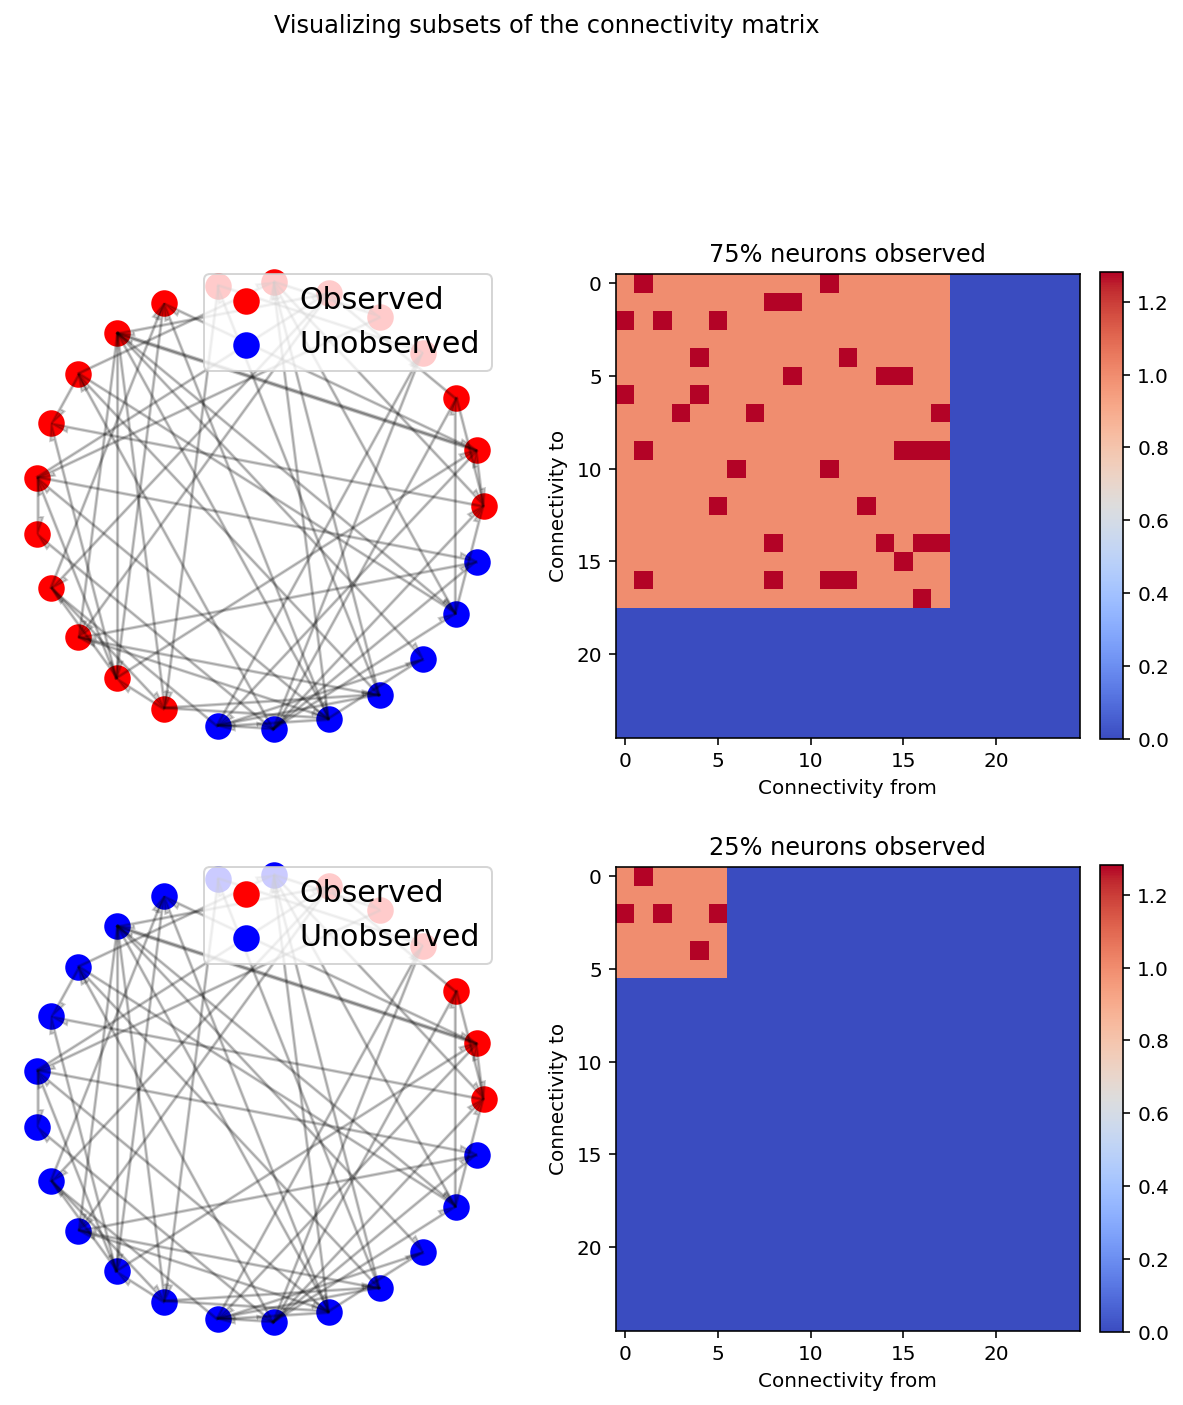

In [18]:
#@markdown Execute this cell to visualize subsets of connectivity matrix

# Run this cell to visualize the subsets of variables we observe
n_neurons = 25
A = create_connectivity(n_neurons)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ratio_observed = [0.75, 0.25]  # the proportion of neurons observed in our system

for i, ratio in enumerate(ratio_observed):
    sel_idx = int(n_neurons * ratio)

    offset = np.zeros((n_neurons, n_neurons))
    axs[i,1].title.set_text("{}% neurons observed".format(int(ratio * 100)))
    offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
    im = axs[i, 1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
    axs[i, 1].set_xlabel("Connectivity from")
    axs[i, 1].set_ylabel("Connectivity to")
    plt.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)
    see_neurons(A,axs[i, 0],ratio)

plt.suptitle("Visualizing subsets of the connectivity matrix", y = 1.05)
plt.show()

## Section 4.2: Effects of partial observability

### Interactive Demo: Regression performance as a function of the number of observed neurons

We will first change the number of observed neurons in the network and inspect the resulting estimates of connectivity in this interactive demo. How does the estimated connectivity differ?

**Note:** the plots will take a moment or so to update after moving the slider.

interactive(children=(IntSlider(value=25, description='n_observed', max=45, min=5, step=5), Output()), _dom_cl…

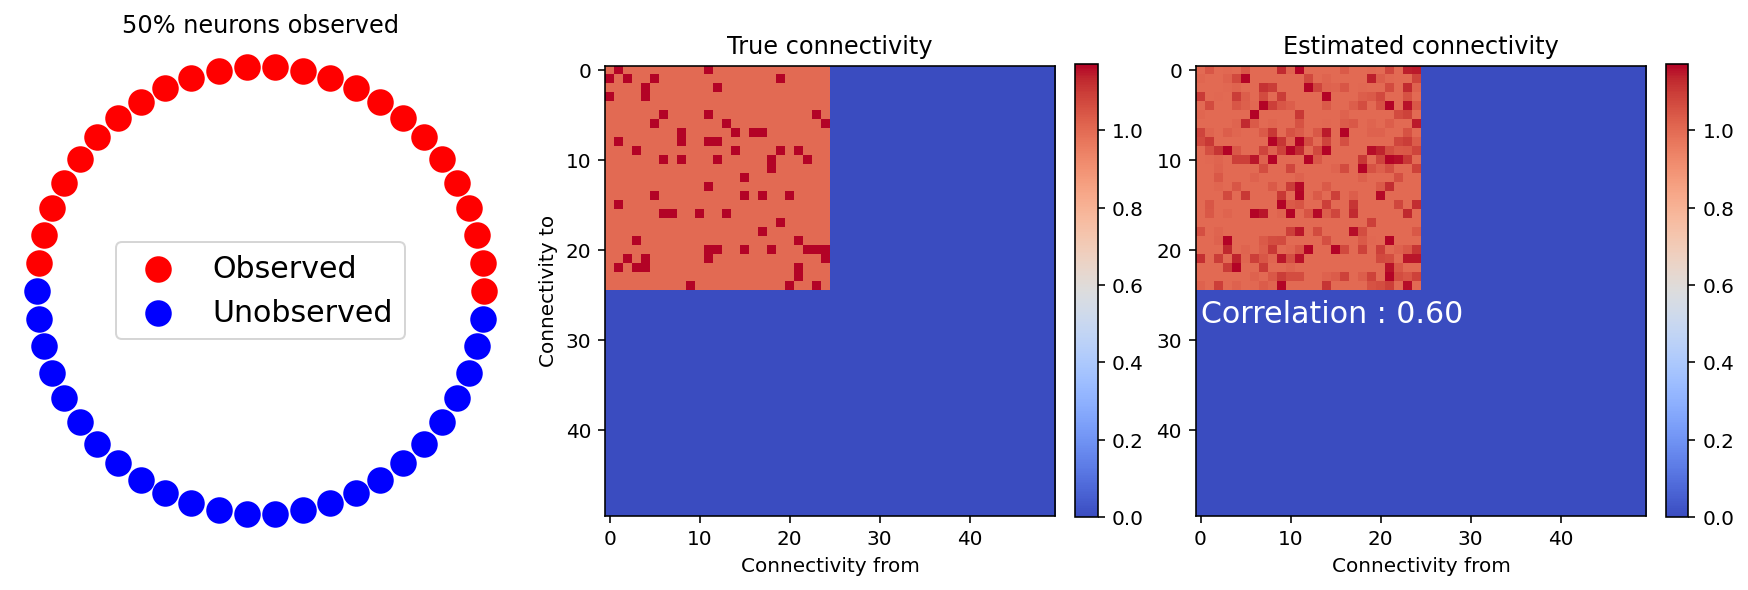

In [19]:
#@markdown Execute this cell to enable demo
n_neurons = 50
A = create_connectivity(n_neurons, random_state=42)
X = simulate_neurons(A, 4000, random_state=42)

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

@widgets.interact
def plot_observed(n_observed=(5, 45, 5)):
  to_neuron = 0
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  sel_idx = n_observed
  ratio = (n_observed) / n_neurons
  offset = np.zeros((n_neurons, n_neurons))
  axs[0].title.set_text("{}% neurons observed".format(int(ratio * 100)))
  offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
  im = axs[1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

  see_neurons(A,axs[0], ratio, False)
  corr, R =  get_regression_corr_full_connectivity(n_neurons,
                                  A,
                                  X,
                                  ratio,
                                  reg_args)

  #rect = patches.Rectangle((-.5,to_neuron-.5),n_observed,1,linewidth=2,edgecolor='k',facecolor='none')
  #axs[1].add_patch(rect)
  big_R = np.zeros(A.shape)
  big_R[:sel_idx, :sel_idx] =  1 + R
  #big_R[to_neuron, :sel_idx] =  1 + R
  im = axs[2].imshow(big_R, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)
  c = 'w' if n_observed<(n_neurons-3) else 'k'
  axs[2].text(0,n_observed+3,"Correlation : {:.2f}".format(corr), color=c, size=15)
  #axs[2].axis("off")
  axs[1].title.set_text("True connectivity")
  axs[1].set_xlabel("Connectivity from")
  axs[1].set_ylabel("Connectivity to")

  axs[2].title.set_text("Estimated connectivity")
  axs[2].set_xlabel("Connectivity from")
  #axs[2].set_ylabel("Connectivity to")

Next, we will inspect a plot of the correlation between true and estimated connectivity matrices vs the percent of neurons observed over multiple trials.
What is the relationship that you see between performance and the number of neurons observed?

**Note:** the cell below will take about 25-30 seconds to run.


simulating trial 1 of 3


/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e+00, tolerance: 5.991e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.035e-01, tolerance: 6.170e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations,

simulating trial 2 of 3


/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.023e-01, tolerance: 6.741e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e+00, tolerance: 7.361e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations,

simulating trial 3 of 3


/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.731e-01, tolerance: 6.676e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+00, tolerance: 6.124e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/kchen/miniconda3/envs/pw3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:646: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations,

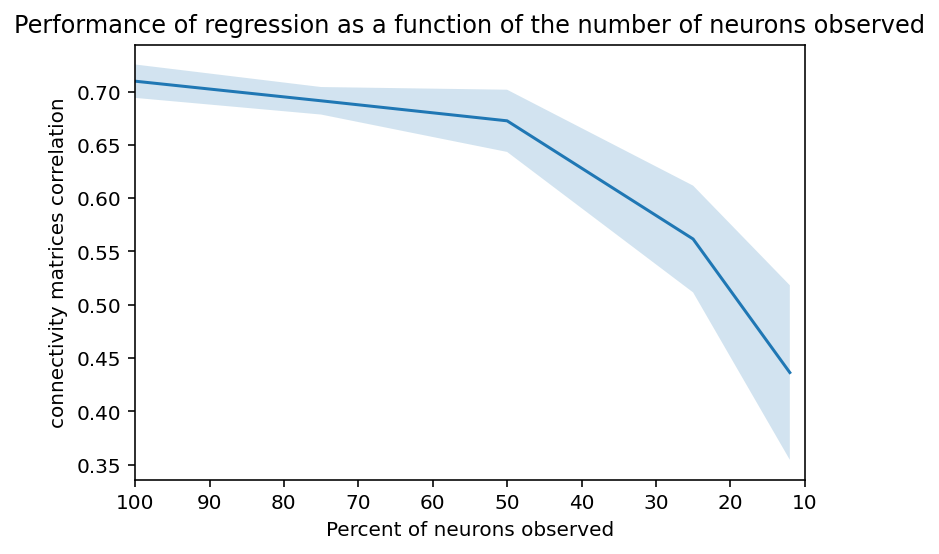

In [20]:
#@title
#@markdown Plot correlation vs. subsampling
import warnings
warnings.filterwarnings('ignore')

# we'll simulate many systems for various ratios of observed neurons
n_neurons = 50
timesteps = 5000
ratio_observed = [1, 0.75, 0.5, .25, .12]  # the proportion of neurons observed in our system
n_trials = 3  # run it this many times to get variability in our results

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

corr_data = np.zeros((n_trials, len(ratio_observed)))
for trial in range(n_trials):

  A = create_connectivity(n_neurons, random_state=trial)
  X = simulate_neurons(A, timesteps)
  print("simulating trial {} of {}".format(trial + 1, n_trials))


  for j, ratio in enumerate(ratio_observed):
      result,_ = get_regression_corr_full_connectivity(n_neurons,
                                    A,
                                    X,
                                    ratio,
                                    reg_args)
      corr_data[trial, j] = result

corr_mean = np.nanmean(corr_data, axis=0)
corr_std = np.nanstd(corr_data, axis=0)

plt.plot(np.asarray(ratio_observed) * 100, corr_mean)
plt.fill_between(np.asarray(ratio_observed) * 100,
                    corr_mean - corr_std,
                    corr_mean + corr_std,
                    alpha=.2)
plt.xlim([100, 10])
plt.xlabel("Percent of neurons observed")
plt.ylabel("connectivity matrices correlation")
plt.title("Performance of regression as a function of the number of neurons observed");